# ML for passholder prediction

### Imports

In [3]:
import sys
import gc
import pickle

from utils import utils
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from fast_ml.feature_engineering import FeatureEngineering_DateTime

from IPython.display import display, HTML

In [36]:
schema={
    'duration':'float64',
    'start_lat':'float64',
    'start_lon':'float64',
    'end_lat':'float64',
    'end_lon':'float64',
    'bike_id':'category',
    'plan_duration':'category',
    'trip_route_category':'category',
    'passholder_type':'category',
    'start_station':'category',
    'end_station':'category'
}

dates=['start_time', 'end_time']

load_train=pd.read_csv('/workspace/data/train_set_cleaned_no_outliers.csv', index_col='trip_id', dtype=schema, parse_dates=dates)

X_test =pd.read_csv('/workspace/data/test_set_cleaned_with_outliers.csv', index_col='trip_id', dtype=schema, parse_dates=dates)
# Features
X_train = load_train.loc[:, (load_train.columns != 'passholder_type') & (load_train.columns != 'plan_duration')]

# Label
y_train = load_train.loc[:, 'passholder_type']

In [37]:
X_test

,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station
trip_id,,,,,,,,,,,
17059130,12.0,2017-01-01 00:24:00,2017-01-01 00:36:00,34.058319,-118.246094,34.058319,-118.246094,6351,Round Trip,3028,3028
17059129,17.0,2017-01-01 00:28:00,2017-01-01 00:45:00,34.049980,-118.247162,34.043732,-118.260139,5836,One Way,3027,3018
17059126,20.0,2017-01-01 00:39:00,2017-01-01 00:59:00,34.063389,-118.236160,34.044159,-118.251579,6529,One Way,3066,3055
17059125,12.0,2017-01-01 00:43:00,2017-01-01 00:55:00,34.048851,-118.246422,34.050140,-118.233238,6029,One Way,3029,3079
17061379,48.0,2017-01-01 00:56:00,2017-01-01 01:44:00,34.049198,-118.252831,34.049198,-118.252831,6680,Round Trip,3063,3063
...,...,...,...,...,...,...,...,...,...,...,...
179408277,19.0,2021-12-31 23:29:00,2021-12-31 23:48:00,34.040989,-118.255798,34.041130,-118.267982,14027,One Way,3033,3011
179408276,8.0,2021-12-31 23:40:00,2021-12-31 23:48:00,34.044701,-118.252441,34.051941,-118.243530,20006,One Way,3031,3030
179409877,43.0,2021-12-31 23:47:00,2022-01-01 00:30:00,34.044701,-118.252441,34.044701,-118.252441,16214,Round Trip,3031,3031


In [38]:
X_train

,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station
trip_id,,,,,,,,,,,
101750280,35.0,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,Round Trip,4127,4127
46560345,32.0,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,6683,One Way,3057,3062
120016336,6.0,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,One Way,3022,3062
129547190,138.0,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,One Way,4304,4311
136619463,14.0,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,18841,One Way,4266,4443
...,...,...,...,...,...,...,...,...,...,...,...
83666862,17.0,2018-04-25 18:32:00,2018-04-25 18:49:00,34.049889,-118.255882,34.074829,-118.258728,06505,One Way,3032,4220
132547303,9.0,2019-11-12 16:49:10,2019-11-12 16:58:51,34.039188,-118.232529,34.056610,-118.237213,18348,One Way,3036,3014
67332628,6.0,2018-01-13 15:49:00,2018-01-13 15:55:00,34.049889,-118.255882,34.050480,-118.254593,05718,One Way,3032,3007


In [39]:
set(X_train.columns)-set(X_test.columns)

set()

In [40]:
# gc
del load_train

### Encoding

In [41]:
# Dates feature Engineering
datetime_vars=['start_time', 'end_time']

dt_fe = FeatureEngineering_DateTime()
dt_fe.fit(X_train, datetime_variables=datetime_vars, prefix = 'default')
X_train = dt_fe.transform(X_train)

dt_fe.fit(X_test, datetime_variables=datetime_vars, prefix = 'default')
X_test = dt_fe.transform(X_test)

/usr/local/lib/python3.9/dist-packages/fast_ml/feature_engineering.py:382: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[pfx+f] = getattr(df[var].dt, f)
/usr/local/lib/python3.9/dist-packages/fast_ml/feature_engineering.py:382: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[pfx+f] = getattr(df[var].dt, f)
/usr/local/lib/python3.9/dist-packages/fast_ml/feature_engineering.py:382: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[pfx+f] = getattr(df[var].dt, f)
/usr/local/lib/python3.9/dist-packages/fast_ml/feature_engineering.py:382: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[pfx+f] = getattr(df[var].dt, f)


In [42]:
pd.options.display.max_columns = None
display(X_train)

,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station,start_time:year,start_time:quarter,start_time:month,start_time:day,start_time:day_of_week,start_time:day_of_year,start_time:weekofyear,start_time:is_month_end,start_time:is_month_start,start_time:is_quarter_end,start_time:is_quarter_start,start_time:is_year_end,start_time:is_year_start,start_time:time,start_time:hour,start_time:minute,start_time:second,start_time:is_weekend,start_time:day_part,end_time:year,end_time:quarter,end_time:month,end_time:day,end_time:day_of_week,end_time:day_of_year,end_time:weekofyear,end_time:is_month_end,end_time:is_month_start,end_time:is_quarter_end,end_time:is_quarter_start,end_time:is_year_end,end_time:is_year_start,end_time:time,end_time:hour,end_time:minute,end_time:second,end_time:is_weekend,end_time:day_part
trip_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101750280,35.0,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,Round Trip,4127,4127,2018,3,8,7,1,219,32,False,False,False,False,False,False,11:20:00,11,20,0,0,noon,2018,3,8,7,1,219,32,False,False,False,False,False,False,11:55:00,11,55,0,0,noon
46560345,32.0,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,6683,One Way,3057,3062,2017,3,9,17,6,260,37,False,False,False,False,False,False,17:51:00,17,51,0,1,evening,2017,3,9,17,6,260,37,False,False,False,False,False,False,18:23:00,18,23,0,1,evening
120016336,6.0,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,One Way,3022,3062,2019,2,4,22,0,112,17,False,False,False,False,False,False,09:22:00,9,22,0,0,late morning,2019,2,4,22,0,112,17,False,False,False,False,False,False,09:28:00,9,28,0,0,late morning
129547190,138.0,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,One Way,4304,4311,2019,3,9,22,6,265,38,False,False,False,False,False,False,11:27:00,11,27,0,1,noon,2019,3,9,22,6,265,38,False,False,False,False,False,False,13:45:00,13,45,0,1,noon
136619463,14.0,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,18841,One Way,4266,4443,2020,1,1,31,4,31,5,True,False,False,False,False,False,17:11:00,17,11,0,0,evening,2020,1,1,31,4,31,5,True,False,False,False,False,False,17:25:00,17,25,0,0,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83666862,17.0,2018-04-25 18:32:00,2018-04-25 18:49:00,34.049889,-118.255882,34.074829,-118.258728,06505,One Way,3032,4220,2018,2,4,25,2,115,17,False,False,False,False,False,False,18:32:00,18,32,0,0,evening,2018,2,4,25,2,115,17,False,False,False,False,False,False,18:49:00,18,49,0,0,evening
132547303,9.0,2019-11-12 16:49:10,2019-11-12 16:58:51,34.039188,-118.232529,34.056610,-118.237213,18348,One Way,3036,3014,2019,4,11,12,1,316,46,False,False,False,False,False,False,16:49:10,16,49,10,0,afternoon,2019,4,11,12,1,316,46,False,False,False,False,False,False,16:58:51,16,58,51,0,afternoon
67332628,6.0,2018-01-13 15:49:00,2018-01-13 15:55:00,34.049889,-118.255882,34.050480,-118.254593,05718,One Way,3032,3007,2018,1,1,13,5,13,2,False,False,False,False,False,False,15:49:00,15,49,0,1,afternoon,2018,1,1,13,5,13,2,False,False,False,False,False,False,15:55:00,15,55,0,1,afternoon


In [43]:
# Find differences between df's columns

for i, col in enumerate(X_train.columns):
    if (X_test[col].dtype == 'category'):
        test_c=set(X_test[col].cat.categories)
        train_c=set(X_train[col].cat.categories)
        compare_sets=(test_c-train_c)

        if(compare_sets == set()):
            continue
        else:
            print(f'Column {col} is has this differences: \n\t > {compare_sets}')


Column bike_id is has this differences: 
	 > {'15917', '15961', '17144', 'Rblock', '16238', '20203', '13658', '15450', '_Test_RFID', '15139', '15150', '15611', '15261', '16571', '15241b', '15229a', '15255', '1349', 'TBlocker_Slash', '16172', '16589', 'Dock Block 1', '20196', '15385', '16037'}
Column start_station is has this differences: 
	 > {'4285', '4362', '4286'}
Column end_station is has this differences: 
	 > {'4285', '4592', '4362', '4286'}


In [44]:
X_train

,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station,start_time:year,start_time:quarter,start_time:month,start_time:day,start_time:day_of_week,start_time:day_of_year,start_time:weekofyear,start_time:is_month_end,start_time:is_month_start,start_time:is_quarter_end,start_time:is_quarter_start,start_time:is_year_end,start_time:is_year_start,start_time:time,start_time:hour,start_time:minute,start_time:second,start_time:is_weekend,start_time:day_part,end_time:year,end_time:quarter,end_time:month,end_time:day,end_time:day_of_week,end_time:day_of_year,end_time:weekofyear,end_time:is_month_end,end_time:is_month_start,end_time:is_quarter_end,end_time:is_quarter_start,end_time:is_year_end,end_time:is_year_start,end_time:time,end_time:hour,end_time:minute,end_time:second,end_time:is_weekend,end_time:day_part
trip_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101750280,35.0,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,Round Trip,4127,4127,2018,3,8,7,1,219,32,False,False,False,False,False,False,11:20:00,11,20,0,0,noon,2018,3,8,7,1,219,32,False,False,False,False,False,False,11:55:00,11,55,0,0,noon
46560345,32.0,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,6683,One Way,3057,3062,2017,3,9,17,6,260,37,False,False,False,False,False,False,17:51:00,17,51,0,1,evening,2017,3,9,17,6,260,37,False,False,False,False,False,False,18:23:00,18,23,0,1,evening
120016336,6.0,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,One Way,3022,3062,2019,2,4,22,0,112,17,False,False,False,False,False,False,09:22:00,9,22,0,0,late morning,2019,2,4,22,0,112,17,False,False,False,False,False,False,09:28:00,9,28,0,0,late morning
129547190,138.0,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,One Way,4304,4311,2019,3,9,22,6,265,38,False,False,False,False,False,False,11:27:00,11,27,0,1,noon,2019,3,9,22,6,265,38,False,False,False,False,False,False,13:45:00,13,45,0,1,noon
136619463,14.0,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,18841,One Way,4266,4443,2020,1,1,31,4,31,5,True,False,False,False,False,False,17:11:00,17,11,0,0,evening,2020,1,1,31,4,31,5,True,False,False,False,False,False,17:25:00,17,25,0,0,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83666862,17.0,2018-04-25 18:32:00,2018-04-25 18:49:00,34.049889,-118.255882,34.074829,-118.258728,06505,One Way,3032,4220,2018,2,4,25,2,115,17,False,False,False,False,False,False,18:32:00,18,32,0,0,evening,2018,2,4,25,2,115,17,False,False,False,False,False,False,18:49:00,18,49,0,0,evening
132547303,9.0,2019-11-12 16:49:10,2019-11-12 16:58:51,34.039188,-118.232529,34.056610,-118.237213,18348,One Way,3036,3014,2019,4,11,12,1,316,46,False,False,False,False,False,False,16:49:10,16,49,10,0,afternoon,2019,4,11,12,1,316,46,False,False,False,False,False,False,16:58:51,16,58,51,0,afternoon
67332628,6.0,2018-01-13 15:49:00,2018-01-13 15:55:00,34.049889,-118.255882,34.050480,-118.254593,05718,One Way,3032,3007,2018,1,1,13,5,13,2,False,False,False,False,False,False,15:49:00,15,49,0,1,afternoon,2018,1,1,13,5,13,2,False,False,False,False,False,False,15:55:00,15,55,0,1,afternoon


In [45]:
X_train.dtypes

duration                              float64
start_time                     datetime64[ns]
end_time                       datetime64[ns]
start_lat                             float64
start_lon                             float64
end_lat                               float64
end_lon                               float64
bike_id                              category
trip_route_category                  category
start_station                        category
end_station                          category
start_time:year                         int64
start_time:quarter                      int64
start_time:month                        int64
start_time:day                          int64
start_time:day_of_week                  int64
start_time:day_of_year                  int64
start_time:weekofyear                   int64
start_time:is_month_end                  bool
start_time:is_month_start                bool
start_time:is_quarter_end                bool
start_time:is_quarter_start       

In [46]:
drop=[  
    'bike_id',
    'start_time',
    'end_time',
    'start_lat',
    'start_lon',
    'end_lat',
    'end_lon',
    'end_time:year',
    'end_time:day_of_year',
    'end_time:second',
    'end_time:minute',
    'end_time:time',
    'end_time:is_month_end',
    'end_time:is_month_start',
    'end_time:is_quarter_end',
    'end_time:is_quarter_start',
    'end_time:is_year_end',
    'end_time:is_year_start',
    'end_time:weekofyear',
    'end_time:quarter',
    'start_time:year',
    'start_time:day_of_year',
    'start_time:second',
    'start_time:minute',
    'start_time:time',
    'start_time:is_month_end',
    'start_time:is_month_start',
    'start_time:is_quarter_end',
    'start_time:is_quarter_start',
    'start_time:is_year_end',
    'start_time:is_year_start',
    'start_time:weekofyear'
    ]


X_train=X_train.drop((drop), axis=1)
X_test=X_test.drop(drop, axis=1)

In [47]:
X_train

,duration,trip_route_category,start_station,end_station,start_time:quarter,start_time:month,start_time:day,start_time:day_of_week,start_time:hour,start_time:is_weekend,start_time:day_part,end_time:month,end_time:day,end_time:day_of_week,end_time:hour,end_time:is_weekend,end_time:day_part
trip_id,,,,,,,,,,,,,,,,,
101750280,35.0,Round Trip,4127,4127,3,8,7,1,11,0,noon,8,7,1,11,0,noon
46560345,32.0,One Way,3057,3062,3,9,17,6,17,1,evening,9,17,6,18,1,evening
120016336,6.0,One Way,3022,3062,2,4,22,0,9,0,late morning,4,22,0,9,0,late morning
129547190,138.0,One Way,4304,4311,3,9,22,6,11,1,noon,9,22,6,13,1,noon
136619463,14.0,One Way,4266,4443,1,1,31,4,17,0,evening,1,31,4,17,0,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83666862,17.0,One Way,3032,4220,2,4,25,2,18,0,evening,4,25,2,18,0,evening
132547303,9.0,One Way,3036,3014,4,11,12,1,16,0,afternoon,11,12,1,16,0,afternoon
67332628,6.0,One Way,3032,3007,1,1,13,5,15,1,afternoon,1,13,5,15,1,afternoon


In [48]:
X_test.dtypes

duration                   float64
trip_route_category       category
start_station             category
end_station               category
start_time:quarter           int64
start_time:month             int64
start_time:day               int64
start_time:day_of_week       int64
start_time:hour              int64
start_time:is_weekend        int64
start_time:day_part         object
end_time:month               int64
end_time:day                 int64
end_time:day_of_week         int64
end_time:hour                int64
end_time:is_weekend          int64
end_time:day_part           object
dtype: object

In [49]:
# Pre-processing functions

def aling_dfs(train, test):
        train_aligned, right_aligned = train.align(test, join="left", axis=1)

        return (train_aligned, right_aligned)


def categorical_imputer(categoricals_df, cols):
        categoricals_df=categoricals_df.loc[:, cols]
        imputer=SimpleImputer(strategy='most_frequent')
        imputed_nans=imputer.fit_transform(categoricals_df)
        return imputed_nans

def categorical_encoder(categoricals_df):
        encoder= OneHotEncoder(handle_unknown='error', sparse_output=False)
        categoricals_encoded=encoder.fit_transform(categoricals_df)

        return categoricals_encoded #END categorical_encoder()

def df_scaler(df): # Scale
        #scaler=RobustScaler()
        #df_scaled=scaler.fit_transform(df)
        transformer = RobustScaler().fit(df)
        df_scaled=transformer.transform(df)

        return df_scaled # END df_scaler()

In [16]:
# Align
train_aligned, test_aligned=aling_dfs(X_train, X_test)

In [17]:
# Impute categoricals
categoricals=['trip_route_category', 'start_station', 'end_station', 'start_time:day_part', 'end_time:day_part']

train_imputed_categoricals=categorical_imputer(train_aligned, categoricals)
test_imputed_categoricals=categorical_imputer(test_aligned, categoricals)

In [20]:
# Scale numericals
numericals=[
    'duration',
    'start_time:month',
    'start_time:quarter',
    'start_time:day',
    'start_time:day_of_week',
    'start_time:hour',
    'start_time:is_weekend',
    'end_time:month',
    'end_time:day',
    'end_time:day_of_week',
    'end_time:hour',
    'end_time:is_weekend'
 ]

numericals_scaled_train=df_scaler(train_aligned.loc[:, numericals])

In [21]:
numericals_scaled_test=df_scaler(test_aligned.loc[:, numericals])

# GC
del train_aligned
del test_aligned

In [22]:
# Encode categoricals
categoricals_encoded_train=categorical_encoder(train_imputed_categoricals)
categoricals_encoded_test=categorical_encoder(test_imputed_categoricals)

# GC
del train_imputed_categoricals
del test_imputed_categoricals

In [23]:
categoricals_scaled_train=df_scaler(categoricals_encoded_train)

#GC
del categoricals_encoded_train

In [24]:
categoricals_scaled_test=df_scaler(categoricals_encoded_test)

# GC
del categoricals_encoded_test

In [25]:
train_output=np.concatenate([categoricals_scaled_train, numericals_scaled_train], axis=1)

In [26]:
del categoricals_scaled_train
del numericals_scaled_train

In [27]:
test_output=np.concatenate([categoricals_scaled_test, numericals_scaled_test], axis=1)

del categoricals_scaled_test
del numericals_scaled_test

In [28]:
np.save('/workspace/data/test_output.npy', test_output)
np.save('/workspace/data/train_output.npy', train_output)

### Resampling strategies

In [4]:
schema={
    'duration':'float64',
    'start_lat':'float64',
    'start_lon':'float64',
    'end_lat':'float64',
    'end_lon':'float64',
    'bike_id':'category',
    'plan_duration':'category',
    'trip_route_category':'category',
    'passholder_type':'category',
    'start_station':'category',
    'end_station':'category'
}

dates=['start_time', 'end_time']

# Load DF's
#y_train=pd.read_csv('/workspace/data/train_set_cleaned_no_out.csv', index_col='trip_id', dtype=schema, parse_dates=dates)
#y_train=pd.read_csv('/workspace/data/train_set_cleaned_with_outliers.csv', index_col='trip_id', dtype=schema, parse_dates=dates)

load_train=pd.read_csv('/workspace/data/train_set_cleaned_no_outliers.csv', index_col='trip_id', dtype=schema, parse_dates=dates)
y_train = load_train.loc[:, 'passholder_type']

X_train_for_predict=np.load('/workspace/data/train_output.npy')

In [5]:
del load_train

In [6]:
y_train.shape

(675427,)

In [7]:
X_train_for_predict.shape

(675427, 760)

#### Sampling

In [8]:
y_train.value_counts()

Monthly Pass    387279
Walk-up         203867
One Day Pass     39888
Annual Pass      32973
Flex Pass        11420
Name: passholder_type, dtype: int64

Class=4, n=203867 (30.183%)
Class=2, n=387279 (57.338%)
Class=3, n=39888 (5.906%)
Class=0, n=32973 (4.882%)
Class=1, n=11420 (1.691%)


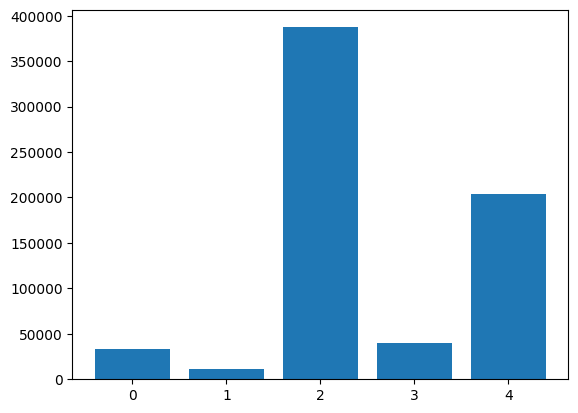

In [9]:
y = LabelEncoder().fit_transform(y_train)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [10]:
from imblearn.over_sampling import SMOTE

smote_sampling_dict={'Annual Pass':50000, 'Flex Pass':40000, 'Monthly Pass':387279, 'One Day Pass':50000, 'Walk-up':203867}
over = SMOTE(sampling_strategy=smote_sampling_dict)
X_sampled, y_sampled = over.fit_resample(X_train_for_predict, y_train)

#random_sampling_dict={'Annual Pass':50000, 'Flex Pass':40000, 'Monthly Pass':60000, 'One Day Pass':50000, 'Walk-up':55000}
#under = RandomUnderSampler(sampling_strategy=random_sampling_dict)

#steps = [('o', over), ('u', under)]
#pipeline = Pipeline(steps=steps)

#X_sampled, y_sampled = pipeline.fit_resample(X_train_for_predict, y_train)

In [11]:
y_sampled.value_counts()

Monthly Pass    387279
Walk-up         203867
Annual Pass      50000
One Day Pass     50000
Flex Pass        40000
Name: passholder_type, dtype: int64

<AxesSubplot: >

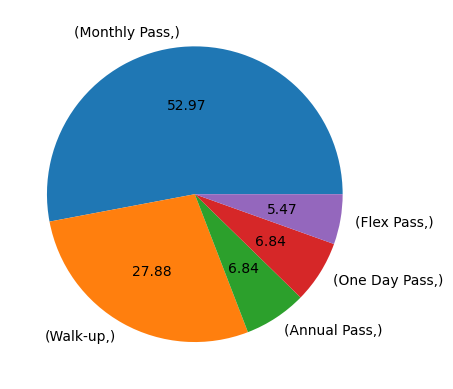

In [12]:
autopct="%.2f"
pd.DataFrame(y_sampled).value_counts().plot.pie(autopct=autopct)

In [13]:
random_sampling_dict={'Annual Pass':50000, 'Flex Pass':40000, 'Monthly Pass':60000, 'One Day Pass':50000, 'Walk-up':55000}
under = RandomUnderSampler(sampling_strategy=random_sampling_dict)

X_sampled, y_sampled = under.fit_resample(X_sampled, y_sampled)

In [14]:
y_sampled.value_counts()

Monthly Pass    60000
Walk-up         55000
Annual Pass     50000
One Day Pass    50000
Flex Pass       40000
Name: passholder_type, dtype: int64

<AxesSubplot: >

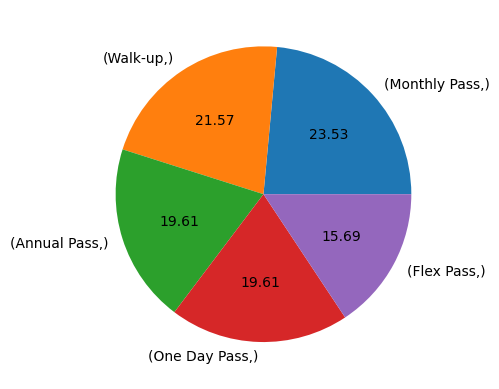

In [15]:
autopct="%.2f"
pd.DataFrame(y_sampled).value_counts().plot.pie(autopct=autopct)

### Training

#### Baseline model

In [117]:
# define model with resampled data
model = DecisionTreeClassifier()
# Encode Labels
label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_sampled)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_sampled, le_y_under, scoring='roc_auc_ovo', cv=cv, n_jobs=-1) # summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean ROC AUC: 0.644


In [43]:
list(label_encoder.classes_)

['Annual Pass', 'Flex Pass', 'Monthly Pass', 'One Day Pass', 'Walk-up']

In [125]:
# BAGGING
model = BaggingClassifier()
# Encode Labels
label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_sampled)
# evaluate the model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
n_scores = cross_val_score(model, X_sampled, le_y_under, scoring='roc_auc_ovo', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.778 (0.003)


In [18]:
# BAGGING Hyper Tuning w/ Grid Search
label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_sampled)


In [19]:

bagging=BaggingClassifier()

param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_samples': [0.3, 0.6, 1.0]
}


In [20]:

model_grid = GridSearchCV(bagging, param_grid=param_grid, cv=7, scoring='roc_auc_ovo',)


In [21]:
model_grid.fit(X_sampled, le_y_under)

In [15]:
print("Best params: "+str(model_grid.best_params_))
print("Best Score: "+str(model_grid.best_score_)+'\n')

scores = pd.DataFrame(model_grid.cv_results_)
scores

Best params: {'max_samples': 0.3, 'n_estimators': 1000}
Best Score: 0.8201791651007344



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0.598893,0.009601,0.027576,0.000799,0.3,10,"{'max_samples': 0.3, 'n_estimators': 10}",0.782418,0.784544,0.779394,0.785515,0.783530,0.784179,0.781784,0.783052,0.001897,16
1,3.019518,0.143900,0.092405,0.005617,0.3,50,"{'max_samples': 0.3, 'n_estimators': 50}",0.812866,0.813864,0.809980,0.811309,0.811470,0.814906,0.806789,0.811598,0.002494,8
2,5.902701,0.061751,0.169976,0.002648,0.3,100,"{'max_samples': 0.3, 'n_estimators': 100}",0.818539,0.819366,0.814192,0.817345,0.814752,0.819130,0.810647,0.816282,0.002984,4
3,17.595210,0.132560,0.488489,0.008713,0.3,300,"{'max_samples': 0.3, 'n_estimators': 300}",0.821350,0.820995,0.815913,0.820899,0.819283,0.822436,0.814742,0.819374,0.002717,3
4,28.992710,0.165013,0.803566,0.019600,0.3,500,"{'max_samples': 0.3, 'n_estimators': 500}",0.820636,0.822259,0.816065,0.820840,0.819722,0.822141,0.815207,0.819553,0.002617,2
5,58.341060,0.357188,1.714560,0.032318,0.3,1000,"{'max_samples': 0.3, 'n_estimators': 1000}",0.820907,0.822665,0.816987,0.821395,0.820164,0.823160,0.815976,0.820179,0.002533,1
6,1.038917,0.012077,0.029716,0.000863,0.6,10,"{'max_samples': 0.6, 'n_estimators': 10}",0.782983,0.784239,0.776446,0.775476,0.775683,0.785226,0.776126,0.779454,0.004120,17
7,5.181805,0.039443,0.107286,0.001569,0.6,50,"{'max_samples': 0.6, 'n_estimators': 50}",0.807742,0.808816,0.803859,0.808631,0.805609,0.809123,0.803311,0.806727,0.002265,12
8,10.387911,0.076043,0.206435,0.004440,0.6,100,"{'max_samples': 0.6, 'n_estimators': 100}",0.810742,0.812574,0.807803,0.809372,0.809256,0.813774,0.807118,0.810091,0.002250,9
9,31.056039,0.426153,0.576405,0.027207,0.6,300,"{'max_samples': 0.6, 'n_estimators': 300}",0.814318,0.815199,0.809802,0.813080,0.811781,0.815581,0.808257,0.812574,0.002568,7


In [16]:
print("Best Score: "+str(model_grid.best_params_)+'\n')

Best Score: {'max_samples': 0.3, 'n_estimators': 1000}



In [24]:
model_grid

GridSearchCV(cv=7, estimator=BaggingClassifier(),
             param_grid={'max_samples': [0.3, 0.6, 1.0],
                         'n_estimators': [10, 50, 100, 300, 500, 1000]},
             scoring='roc_auc_ovo')

In [21]:
# save the model to disk
filename = '/workspace/data/bagging_model.sav'
pickle.dump(model, open(filename, 'wb'))

#### Test model grid

In [130]:
y_preds = model_grid.predict(X_test_for_predict)

In [132]:
pred_labels=[]

for pred in y_preds:
    pred_labels.append(label_encoder.classes_[pred])

In [133]:
predictions = pd.DataFrame()
predictions['trip_id']=X_test.index
predictions['passholder_type']=pred_labels
predictions=predictions.set_index('trip_id')

In [135]:
predictions.to_csv('/workspace/data/passholder_type_submission.csv')

In [17]:
# BAGGING Hyper Tuning w/ Grid Search

label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_under)

bagging_2=BaggingClassifier()

param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'max_samples': [0.3]
}

model_grid_2 = GridSearchCV(bagging, param_grid=param_grid, cv=7, scoring='roc_auc_ovo',)
model_grid_2.fit(X_under, le_y_under)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=7, estimator=BaggingClassifier(),
             param_grid={'max_samples': [0.3],
                         'n_estimators': [1000, 1500, 2000]},
             scoring='roc_auc_ovo')

In [18]:
print("Best params: "+str(model_grid_2.best_params_))
print("Best Score: "+str(model_grid_2.best_score_)+'\n')

scores_2 = pd.DataFrame(model_grid_2.cv_results_)
scores_2

Best params: {'max_samples': 0.3, 'n_estimators': 2000}
Best Score: 0.8205091657304625



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,59.284509,0.422291,1.616113,0.074452,0.3,1000,"{'max_samples': 0.3, 'n_estimators': 1000}",0.821056,0.822654,0.817384,0.821458,0.820268,0.823003,0.815851,0.820239,0.002479,3
1,89.170319,0.486918,2.586479,0.170092,0.3,1500,"{'max_samples': 0.3, 'n_estimators': 1500}",0.821080,0.823085,0.817341,0.821355,0.820309,0.823124,0.816191,0.820355,0.002481,2
2,118.742305,0.533713,3.525511,0.313141,0.3,2000,"{'max_samples': 0.3, 'n_estimators': 2000}",0.821528,0.823120,0.817235,0.821614,0.820777,0.823259,0.816031,0.820509,0.002605,1


In [20]:
print("Best Score: "+str(model_grid_2.best_params_)+'\n')

Best Score: {'max_samples': 0.3, 'n_estimators': 2000}



#### Predict

In [67]:
model.fit(train_output, y_train)

LogisticRegression(C=0.5, max_iter=1000, multi_class='multinomial')

In [71]:
test_output[:3]

array([[-1.        ,  1.        , -0.05555556, -1.        , -1.        ,
        -1.        ,  0.75      ,  0.        ,  0.        ,  0.        ,
        -2.14285714,  1.        , -1.        , -1.        , -1.        ,
         0.75      , -2.14285714,  1.        ],
       [ 0.        ,  0.        ,  0.22222222, -1.        , -1.        ,
        -1.        ,  0.75      ,  0.        ,  0.        ,  0.        ,
        -2.14285714,  1.        , -1.        , -1.        , -1.        ,
         0.75      , -2.14285714,  1.        ],
       [ 0.        ,  0.        ,  0.38888889, -1.        , -1.        ,
        -1.        ,  0.75      ,  0.        ,  0.        ,  0.        ,
        -2.14285714,  1.        , -1.        , -1.        , -1.        ,
         0.75      , -2.14285714,  1.        ]])

In [81]:
y_pred=model.predict_proba(test_output)


#### AdaBoost Model

In [29]:
# BAGGING Hyper Tuning w/ Grid Search

label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_under)

param_grid = {
    'n_estimators': [50, 100, 200, 250, 500],
    'learning_rate': [0.6, 0.3, 0.1, 0.01, 0.001, 0.0001],
    'random_state': [1437]
}

ADB_model = AdaBoostClassifier()

ADA_model_grid = GridSearchCV(ADB_model, param_grid=param_grid, cv=7, scoring='roc_auc_ovo',)
ADA_model_grid.fit(X_under, le_y_under)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=7, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.6, 0.3, 0.1, 0.01, 0.001, 0.0001],
                         'n_estimators': [50, 100, 200, 250, 500],
                         'random_state': [1437]},
             scoring='roc_auc_ovo')